# Imports

In [2]:
# !python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
# !python -c "import matplotlib" || pip install -q matplotlib
# %matplotlib inline

In [3]:
# Standard Libraries
import os
import io
import math
import time
import random
import tempfile
import warnings
from multiprocessing import Manager
from typing import Optional
import tqdm
# Third-party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import SimpleITK as sitk
import torch
import torch.nn as nn
import torchio as tio
from torch.utils.data import DataLoader, Dataset, random_split
from torch.cuda.amp import GradScaler, autocast

# MONAI Libraries
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism

# Custom Libraries
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler
from dataloader import Train ,Eval 

# Configuration
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")
warnings.filterwarnings('ignore')


JUPYTER_ALLOW_INSECURE_WRITES=True

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


# Set seeds and configs

In [4]:
# Initialize Configuration
config = {
    'batch_size': 1,
    'imgDimResize': (160, 192, 160),
    'imgDimPad': (208, 256, 208),
    'spatialDims': '3D',
    'unisotropic_sampling': True,
    'perc_low': 1,
    'perc_high': 99,
    'rescaleFactor': 2,
    'base_path': '/scratch1/akrami/Latest_Data/Data',
}

# Seed and Device Configuration
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CUDA and CUDNN Configuration
# Uncomment the following line to specify CUDA_VISIBLE_DEVICES
# os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,5,6'
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# SimpleITK Configuration
# Set the default number of threads and global behavior for SimpleITK
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")



True

# Load the data

In [5]:
imgpath = {}
csvpath_trains=['./combined.csv']
pathBase = '/scratch1/akrami/Data_train'
csvpath_val = './Data/splits/IXI_val_fold0.csv'
csvpath_test = './Data/splits/Brats21_sub_test.csv'
var_csv = {}
states = ['train','val','test']
df_list = []

# Loop through each CSV file path and read it into a DataFrame
for csvpath in csvpath_trains:
    df = pd.read_csv(csvpath)
    df_list.append(df)

# %%
var_csv['train'] =pd.concat(df_list, ignore_index=True)
var_csv['val'] = pd.read_csv(csvpath_val)
var_csv['test'] = pd.read_csv(csvpath_test)
# if cfg.mode == 't2':
#     keep_t2 = pd.read_csv(cfg.path.IXI.keep_t2) # only keep t2 images that have a t1 counterpart

for state in states:
    var_csv[state]['settype'] = state
    var_csv[state]['norm_path'] =''
    var_csv[state]['img_path'] = pathBase  + var_csv[state]['img_path']
    var_csv[state]['mask_path'] = pathBase  + var_csv[state]['mask_path']
    if state =='test':
        var_csv[state]['seg_path'] =  pathBase  + var_csv[state]['seg_path']
    else:
        var_csv[state]['seg_path'] =  pathBase  + var_csv[state]['mask_path']
        



data_train = Train(var_csv['train'],config) 
data_val = Train(var_csv['val'],config)                
data_test = Eval(var_csv['test'],config)



#data_train = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_train_fold0.csv', converters={'img_path': pd.eval}), config)
#train_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_val = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_val_fold0.csv', converters={'img_path': pd.eval}), config)
val_loader = DataLoader(data_val, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_test = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/Brats21_test.csv', converters={'img_path': pd.eval}), config)
test_loader = DataLoader(data_test, batch_size=1,shuffle=False,num_workers=8)


device = torch.device("cuda")

In [6]:
test_loader = DataLoader(data_test, batch_size=1,shuffle=False,num_workers=8)

# Load the model

In [7]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[32, 64, 128, 128],
    attention_levels=[False, False, False,True],
    num_head_channels=[0, 0, 0,32],
    num_res_blocks=2,
)
model.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)

inferer = DiffusionInferer(scheduler)

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)

Using 2 GPUs!


In [8]:
# specify your model filename
#model_filename = '/scratch1/akrami/models/3Ddiffusion/half/model_epoch984.pt'
model_filename ='/project/ajoshi_27/akrami/3D_lesion_DF/models/half/model_epoch549.pt'
# load state_dict into the model
model.load_state_dict(torch.load(model_filename))

# if you need to set the model in evaluation mode
model.eval()

DataParallel(
  (module): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
       

# Generate an Image

In [9]:
def denoise(noised_img,sample_time,scheduler,inferer,model):
    with torch.no_grad():
        with autocast(enabled=True):
            for t in range(sample_time - 1, -1, -1):
                batch_size = noised_img.size(0)  # Get the batch size
                t_batch=torch.Tensor((t,)).to(noised_img.device)
                t_batch = t_batch.unsqueeze(0).expand(batch_size, -1)  # Expand tensor `t` to have the desired batch size
                t_batch = t_batch.to(noised_img.device)[:,0] 
                model_output = model(noised_img, timesteps=t_batch)
                noised_img, _ = scheduler.step(model_output, t, noised_img)
            return noised_img

    

In [10]:
import os

# Set your directory path
output_directory = './results/batch_recon'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [11]:
from monai.losses.ssim_loss import SSIMLoss
from monai.losses import MaskedLoss
from monai.losses import MaskedDiceLoss
# ssim_loss = MaskedLoss(SSIMLoss,spatial_dims=3)
dice_loss = MaskedDiceLoss()
ssim_loss = MaskedLoss(SSIMLoss,spatial_dims=3, data_range=1)

import torch
from scipy.stats import norm
import numpy as np
import statsmodels.stats.multitest as mt



  0%|          | 0/100 [00:00<?, ?it/s]

tensor(2.8868, device='cuda:0')


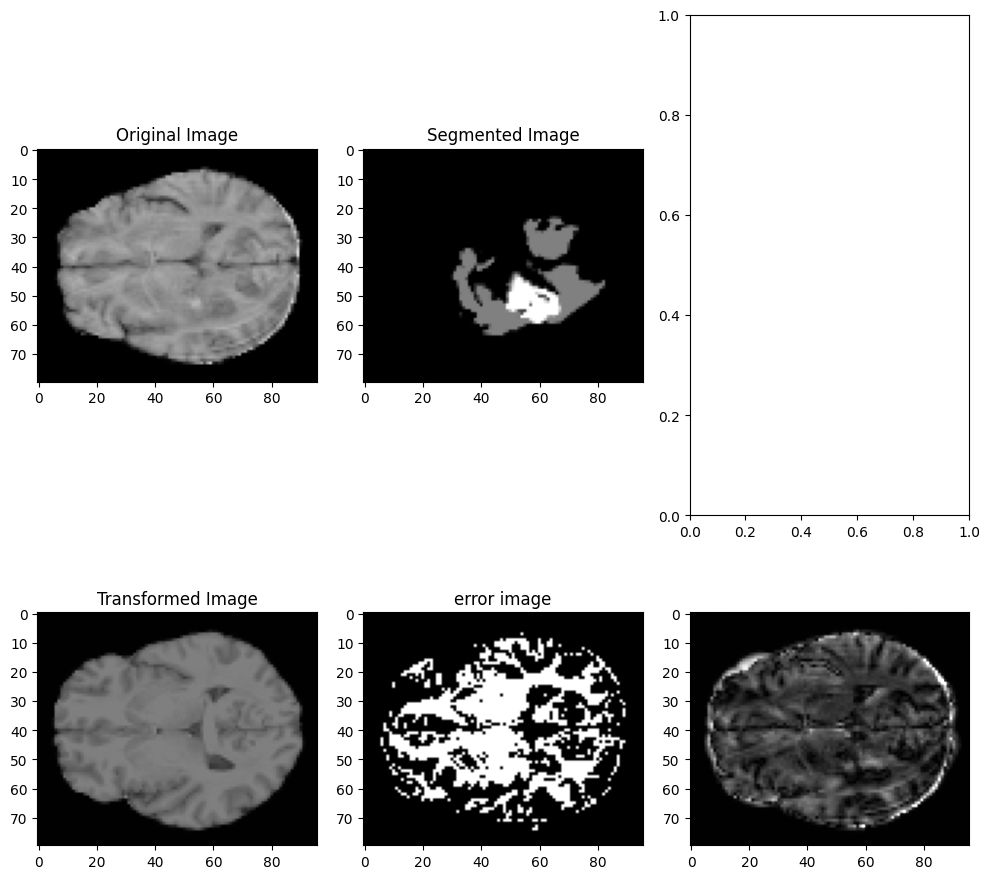

  1%|          | 1/100 [10:38<17:33:12, 638.30s/it]

tensor(1.3669, device='cuda:0')


  2%|▏         | 2/100 [21:11<17:18:05, 635.56s/it]

tensor(2.3052, device='cuda:0')


  3%|▎         | 3/100 [31:45<17:06:03, 634.68s/it]

tensor(1.6747, device='cuda:0')


  4%|▍         | 4/100 [42:19<16:54:50, 634.27s/it]

tensor(1.8055, device='cuda:0')


  5%|▌         | 5/100 [52:53<16:44:03, 634.14s/it]

tensor(1.5336, device='cuda:0')


  6%|▌         | 6/100 [1:03:26<16:33:17, 634.01s/it]

tensor(1.4005, device='cuda:0')


  7%|▋         | 7/100 [1:14:00<16:22:40, 633.98s/it]

tensor(1.8370, device='cuda:0')


  8%|▊         | 8/100 [1:24:34<16:11:54, 633.86s/it]

tensor(2.1001, device='cuda:0')


  9%|▉         | 9/100 [1:35:08<16:01:21, 633.86s/it]

tensor(2.1662, device='cuda:0')


 10%|█         | 10/100 [1:45:42<15:50:52, 633.92s/it]

tensor(1.3904, device='cuda:0')


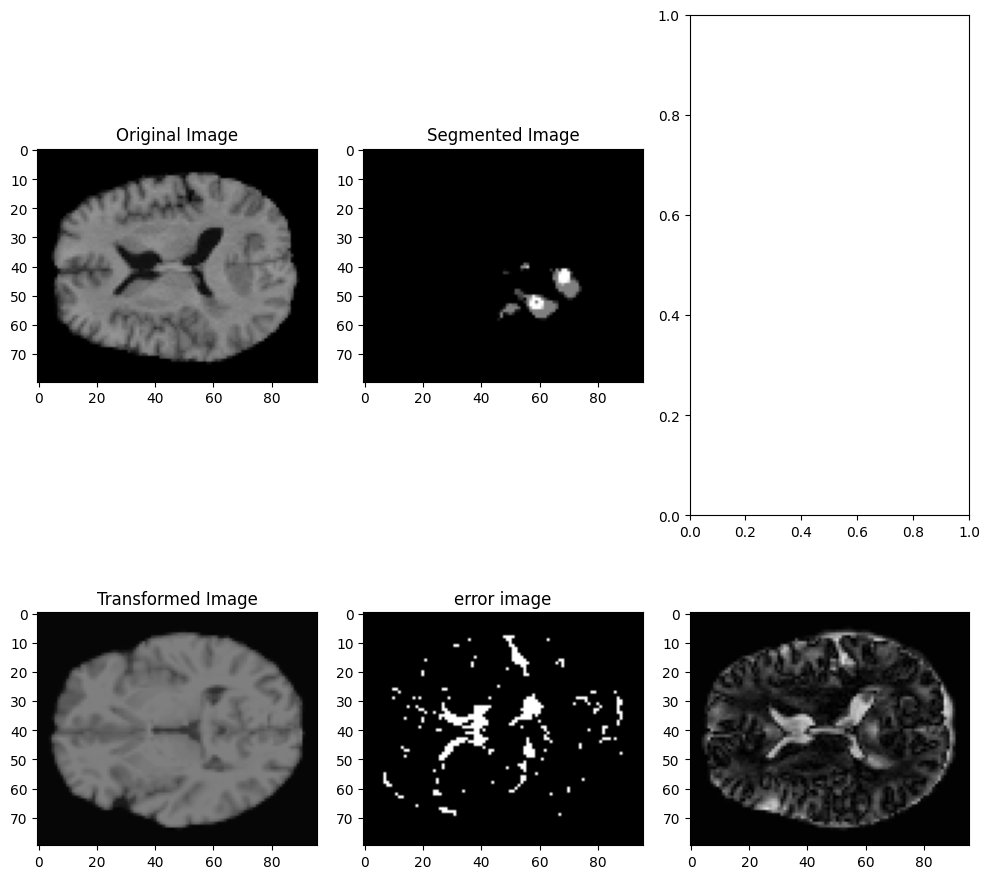

 11%|█         | 11/100 [1:56:18<15:41:24, 634.65s/it]

tensor(1.7718, device='cuda:0')


 12%|█▏        | 12/100 [2:06:53<15:30:49, 634.65s/it]

tensor(1.3973, device='cuda:0')


 13%|█▎        | 13/100 [2:17:26<15:19:49, 634.36s/it]

tensor(1.7536, device='cuda:0')


 14%|█▍        | 14/100 [2:28:01<15:09:13, 634.35s/it]

tensor(1.2862, device='cuda:0')


 15%|█▌        | 15/100 [2:38:36<14:59:06, 634.66s/it]

tensor(2.2913, device='cuda:0')


 16%|█▌        | 16/100 [2:49:11<14:48:24, 634.58s/it]

tensor(1.5888, device='cuda:0')


 17%|█▋        | 17/100 [2:59:44<14:37:32, 634.37s/it]

tensor(1.4776, device='cuda:0')


 18%|█▊        | 18/100 [3:10:18<14:26:46, 634.23s/it]

tensor(2.2042, device='cuda:0')


 19%|█▉        | 19/100 [3:20:53<14:16:13, 634.24s/it]

tensor(1.8821, device='cuda:0')


 20%|██        | 20/100 [3:31:27<14:05:36, 634.21s/it]

tensor(1.7447, device='cuda:0')


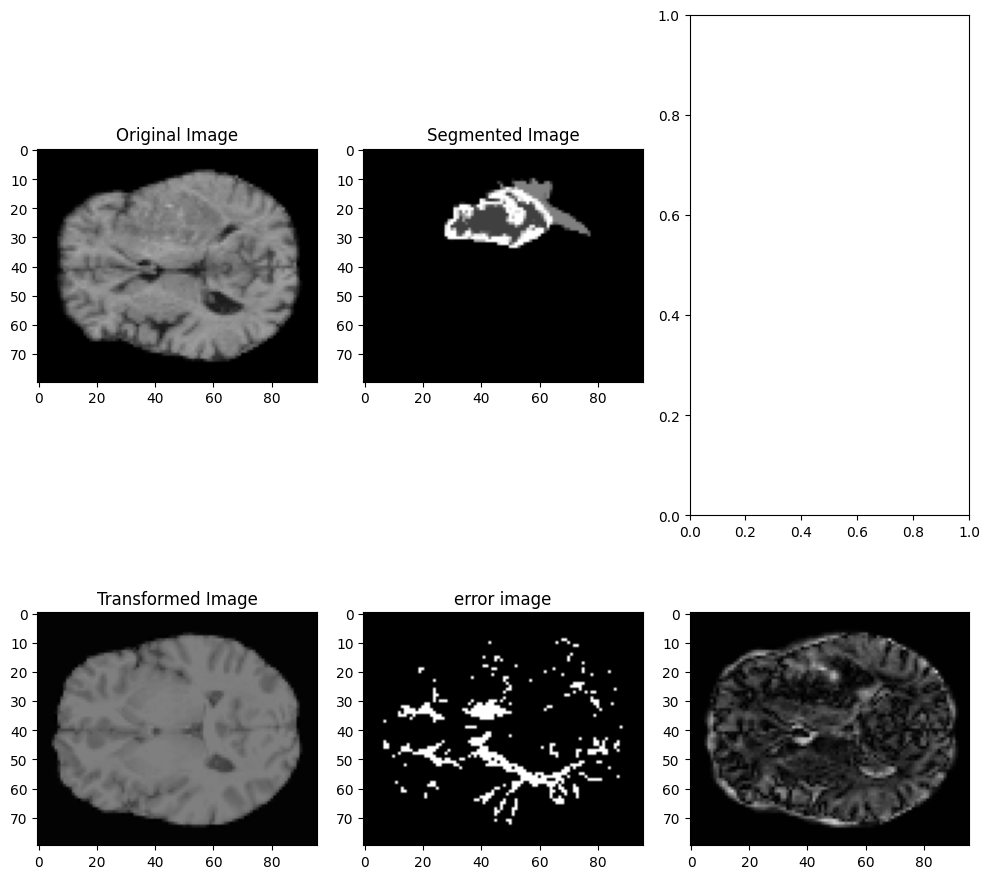

 21%|██        | 21/100 [3:42:02<13:55:27, 634.53s/it]

tensor(1.3136, device='cuda:0')


 22%|██▏       | 22/100 [3:52:36<13:44:35, 634.31s/it]

tensor(2.3134, device='cuda:0')


 23%|██▎       | 23/100 [4:03:10<13:33:49, 634.15s/it]

tensor(3.2662, device='cuda:0')


 24%|██▍       | 24/100 [4:13:44<13:23:11, 634.10s/it]

tensor(1.4329, device='cuda:0')


 25%|██▌       | 25/100 [4:24:19<13:12:58, 634.37s/it]

tensor(1.9849, device='cuda:0')


 26%|██▌       | 26/100 [4:34:52<13:02:12, 634.22s/it]

tensor(1.3017, device='cuda:0')


 27%|██▋       | 27/100 [4:45:27<12:51:35, 634.19s/it]

tensor(2.3013, device='cuda:0')


 28%|██▊       | 28/100 [4:56:00<12:40:54, 634.10s/it]

tensor(1.9125, device='cuda:0')


 29%|██▉       | 29/100 [5:06:35<12:30:21, 634.11s/it]

tensor(1.6530, device='cuda:0')


In [ ]:
# =================== Test Loop for Dice Calculation ===================

# def dice_coefficient(prediction, target):
#     """Compute the Dice coefficient only for non-background region."""
#     smooth = 1.0
#     mask = target > 0  # mask of non-zero (non-background) values
    
#     intersection = (prediction * target * mask).sum()
#     return (2. * intersection + smooth) / ((prediction * mask).sum() + (target * mask).sum() + smooth)

n=5
i=0
all_dices = []
all_ssim_values=[]
sample_time = 999
alpha = 0.01
for step, batch in tqdm.tqdm(enumerate(test_loader), total=len(test_loader)):
    images = batch['vol']['data'].to(device)
    # Expand the dimensions of batch['peak'] to make it [1, 1, 1, 1, 4]
    peak_expanded = (batch['peak'].unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)).long()
    peak_expanded = peak_expanded.to(device)
    images = (images / peak_expanded)
    middle_slice_idx = images.size(-1) // 2  # Define middle_slice_idx here


    repeated_image_array = images.repeat(n, 1, 1, 1, 1) 
    data_range = images.max()
    print(data_range)
    ssim_loss = MaskedLoss(SSIMLoss,spatial_dims=3, data_range=data_range)
    
    

    noise = torch.randn_like(repeated_image_array)
    noisy_img = scheduler.add_noise(original_samples=repeated_image_array, noise=noise, timesteps=torch.tensor(sample_time))
    noisy_img = noisy_img.to(device)
    denoised_sample = denoise(noisy_img, sample_time, scheduler, inferer, model)


    mean_denoised = torch.mean(denoised_sample[:,0][:,:,:].squeeze(), dim=0).cpu().numpy()
    variance_denoised = torch.std(denoised_sample[:,0][:,:,:].squeeze(), dim=0).cpu().numpy()

    
    error = np.abs(repeated_image_array[i][0].squeeze().cpu().numpy()-mean_denoised)
    x =repeated_image_array[0,0,:,:,:].squeeze().cpu().numpy() 
    z_scores = (error)/ (variance_denoised+0.000001)
    
    p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))
    p_values_flattened = p_values.flatten()
    reject, q_values_corrected, _, _ = mt.multipletests(p_values_flattened, method='fdr_bh')
    q_values_tensor_corrected = torch.tensor(q_values_corrected.reshape(x.shape))

    
    thresholded_error = torch.from_numpy(np.where(q_values_tensor_corrected< alpha, 1, 0)).unsqueeze(0).unsqueeze(0).to(device)
    gt_segmentation = (batch['seg']['data']>0).float().to(device)
    
  
    non_background_mask = (images > 0).float()
    gt_segmentation = batch['seg']['data'].to(device)
    non_segmented_mask = (gt_segmentation == 0).float()
    combined_mask = non_background_mask * non_segmented_mask

    # Apply the combined mask to the original and denoised images
    # masked_original = images 
    # masked_denoised = denoised_sample * combined_mask
    
    # Calculate Dice score
    dice_score = 1-dice_loss(thresholded_error, gt_segmentation,non_background_mask)
    all_dices.append(dice_score.item())
    # Calculate SSIM for the regions specified by the combined mask
    ssim_val =1- ssim_loss(images, denoised_sample[0:1,:][:,:,:],combined_mask)
    all_ssim_values.append(ssim_val.item())


    if step % 10 ==0:
        fig, axes = plt.subplots(2, 3, figsize=(10, 10))
        # Original Image
        axes[0, 0].imshow(images[i][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
        axes[0, 0].set_title('Original Image')
        
        # Segmented Image
        image_array_slice = batch['seg']['data'][i][0][:,:,middle_slice_idx].squeeze().cpu().numpy()
        axes[0, 1].imshow(image_array_slice, cmap='gray')
        axes[0, 1].set_title('Segmented Image')
        
        # Transformed Image
        axes[1, 0].imshow(denoised_sample[i][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
        axes[1, 0].set_title('Transformed Image')
        
        # Thresholded Difference Image
        
        axes[1, 1].imshow(thresholded_error[i][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=1, cmap='gray')
        axes[1, 1].set_title('Thresholded Difference Image')

        axes[1, 2].imshow(error[:,:,middle_slice_idx], vmin=0, vmax=1, cmap='gray')
        axes[1, 1].set_title('error image')
        
        # Save the entire figure
        plt.tight_layout()
        
        fig_filename = os.path.join(output_directory, f'test_step_{step}.png')
        plt.savefig(fig_filename)  # Save the figure
        plt.show()

    
# Average Dice score
avg_dice_score = sum(all_dices) / len(all_dices)
print(f"Average Dice score over the test set: {avg_dice_score}")

# Average SSIM values
avg_ssim_value = sum(all_ssim_values) / len(all_ssim_values)
print(f"Average SSIM between specified regions of original and denoised images: {avg_ssim_value}")


In [14]:
 axes[1, 2].imshow(error[:,:,middle_slice_idx].squeeze(), vmin=0, vmax=1, cmap='gray')